# Location-Proximity Analysis Prototype

Manual computation of multi-dimensional proximity using simplified formulas.
This notebook demonstrates the core concepts without using the actual module code.

In [2]:
import json
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## Load Test Data

In [3]:
# Load synthetic dataset
with open('../tests/data/locations.json') as f:
    data = json.load(f)
    locations = data['locations']

print(f"Loaded {len(locations)} locations:")
for loc in locations:
    print(f"- {loc['name']} ({loc['type']})")

Loaded 9 locations:
- Delaney Park Strip (park)
- Chugach State Park (park)
- Westchester Lagoon (park)
- Alaska Native Medical Center (hospital)
- Providence Alaska Medical Center (hospital)
- Alaska Regional Hospital (hospital)
- St. Mary's Catholic Church (church)
- Holy Trinity Orthodox Cathedral (church)
- First Baptist Church (church)


## Manual Proximity Calculations

### 1. Geographic Proximity (Haversine Distance)

In [4]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate distance between two points on Earth using Haversine formula."""
    R = 6371  # Earth's radius in kilometers
    
    # Convert to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    
    return R * c

def geographic_proximity(loc1, loc2, max_distance=20.0):
    """Convert distance to proximity score (0-1)."""
    distance = haversine_distance(
        loc1['coordinates']['lat'], loc1['coordinates']['lon'],
        loc2['coordinates']['lat'], loc2['coordinates']['lon']
    )
    # Normalize: closer = higher proximity
    return max(0, 1 - (distance / max_distance))

# Test with two churches
church1 = locations[6]  # St. Mary's
church2 = locations[7]  # Holy Trinity
geo_prox = geographic_proximity(church1, church2)
print(f"Geographic proximity between {church1['name']} and {church2['name']}: {geo_prox:.3f}")

Geographic proximity between St. Mary's Catholic Church and Holy Trinity Orthodox Cathedral: 0.981


### 2. Categorical Proximity

In [5]:
def categorical_proximity(loc1, loc2):
    """Calculate categorical similarity based on place type."""
    type1, type2 = loc1['type'], loc2['type']
    
    if type1 == type2:
        return 1.0  # Perfect match
    
    # Define related types
    related_types = {
        ('hospital', 'clinic'): 0.5,
        ('church', 'temple'): 0.5,
        ('park', 'garden'): 0.5
    }
    
    # Check if types are related
    for (t1, t2), score in related_types.items():
        if (type1 == t1 and type2 == t2) or (type1 == t2 and type2 == t1):
            return score
    
    return 0.0  # No similarity

# Test categorical proximity
cat_prox = categorical_proximity(church1, church2)
print(f"Categorical proximity between {church1['name']} and {church2['name']}: {cat_prox:.3f}")

hospital1 = locations[3]  # Alaska Native Medical Center
cat_prox_diff = categorical_proximity(church1, hospital1)
print(f"Categorical proximity between {church1['name']} and {hospital1['name']}: {cat_prox_diff:.3f}")

Categorical proximity between St. Mary's Catholic Church and Holy Trinity Orthodox Cathedral: 1.000
Categorical proximity between St. Mary's Catholic Church and Alaska Native Medical Center: 0.000


### 3. Cultural Proximity (Jaccard Similarity)

In [6]:
def cultural_proximity(loc1, loc2):
    """Calculate cultural similarity using Jaccard index."""
    tags1 = set(loc1.get('cultural_tags', []))
    tags2 = set(loc2.get('cultural_tags', []))
    
    if not tags1 and not tags2:
        return 1.0  # Both have no tags
    
    if not tags1 or not tags2:
        return 0.0  # One has no tags
    
    # Jaccard similarity: intersection / union
    intersection = len(tags1.intersection(tags2))
    union = len(tags1.union(tags2))
    
    return intersection / union if union > 0 else 0.0

# Test cultural proximity
cult_prox = cultural_proximity(church1, church2)
print(f"Cultural proximity between {church1['name']} and {church2['name']}: {cult_prox:.3f}")
print(f"Tags: {church1['cultural_tags']} vs {church2['cultural_tags']}")

Cultural proximity between St. Mary's Catholic Church and Holy Trinity Orthodox Cathedral: 0.200
Tags: ['catholic', 'christian', 'traditional'] vs ['orthodox', 'christian', 'historic']


### 4. Linguistic Proximity

In [7]:
def linguistic_proximity(loc1, loc2):
    """Calculate linguistic similarity (binary for now)."""
    lang1 = loc1.get('language', 'unknown')
    lang2 = loc2.get('language', 'unknown')
    
    return 1.0 if lang1 == lang2 else 0.0

# Test linguistic proximity
ling_prox = linguistic_proximity(church1, church2)
print(f"Linguistic proximity between {church1['name']} and {church2['name']}: {ling_prox:.3f}")

Linguistic proximity between St. Mary's Catholic Church and Holy Trinity Orthodox Cathedral: 1.000


### 5. Composite Proximity with Different Weights

In [8]:
def composite_proximity(loc1, loc2, weights=None):
    """Calculate weighted composite proximity."""
    if weights is None:
        weights = {'geo': 0.3, 'cat': 0.4, 'ling': 0.15, 'cult': 0.15}
    
    geo = geographic_proximity(loc1, loc2)
    cat = categorical_proximity(loc1, loc2)
    ling = linguistic_proximity(loc1, loc2)
    cult = cultural_proximity(loc1, loc2)
    
    composite = (weights['geo'] * geo + 
                weights['cat'] * cat + 
                weights['ling'] * ling + 
                weights['cult'] * cult)
    
    return {
        'composite': composite,
        'components': {'geo': geo, 'cat': cat, 'ling': ling, 'cult': cult}
    }

# Test with default weights
result = composite_proximity(church1, church2)
print(f"\nComposite proximity (default weights): {result['composite']:.3f}")
print("Components:")
for comp, score in result['components'].items():
    print(f"  {comp}: {score:.3f}")


Composite proximity (default weights): 0.874
Components:
  geo: 0.981
  cat: 1.000
  ling: 1.000
  cult: 0.200


## Weight Sensitivity Analysis

In [9]:
# Define different weight scenarios
weight_scenarios = {
    'Default': {'geo': 0.3, 'cat': 0.4, 'ling': 0.15, 'cult': 0.15},
    'Geographic Focus': {'geo': 0.7, 'cat': 0.2, 'ling': 0.05, 'cult': 0.05},
    'Categorical Focus': {'geo': 0.1, 'cat': 0.7, 'ling': 0.1, 'cult': 0.1},
    'Cultural Focus': {'geo': 0.1, 'cat': 0.2, 'ling': 0.2, 'cult': 0.5},
    'Equal Weights': {'geo': 0.25, 'cat': 0.25, 'ling': 0.25, 'cult': 0.25}
}

# Test pairs: same type vs different type
test_pairs = [
    (church1, church2, "Church-Church"),
    (locations[3], locations[4], "Hospital-Hospital"),  # Two hospitals
    (locations[0], locations[1], "Park-Park"),  # Two parks
    (church1, locations[3], "Church-Hospital"),  # Different types
    (locations[0], locations[3], "Park-Hospital")  # Different types
]

# Calculate proximities for each scenario
results = {}
for scenario_name, weights in weight_scenarios.items():
    results[scenario_name] = []
    for loc1, loc2, pair_name in test_pairs:
        prox = composite_proximity(loc1, loc2, weights)
        results[scenario_name].append(prox['composite'])

# Display results
pair_names = [pair[2] for pair in test_pairs]
print("Proximity scores under different weighting scenarios:")
print(f"{'Scenario':<18} {' '.join(f'{name:<12}' for name in pair_names)}")
print("-" * 80)
for scenario, scores in results.items():
    score_str = ' '.join(f'{score:<12.3f}' for score in scores)
    print(f"{scenario:<18} {score_str}")

Proximity scores under different weighting scenarios:
Scenario           Church-Church Hospital-Hospital Park-Park    Church-Hospital Park-Hospital
--------------------------------------------------------------------------------
Default            0.874        0.841        0.550        0.399        0.394       
Geographic Focus   0.947        0.869        0.250        0.632        0.620       
Categorical Focus  0.918        0.907        0.800        0.183        0.181       
Cultural Focus     0.598        0.587        0.400        0.283        0.281       
Equal Weights      0.795        0.767        0.500        0.458        0.453       


## Visualization: Weight Impact Analysis

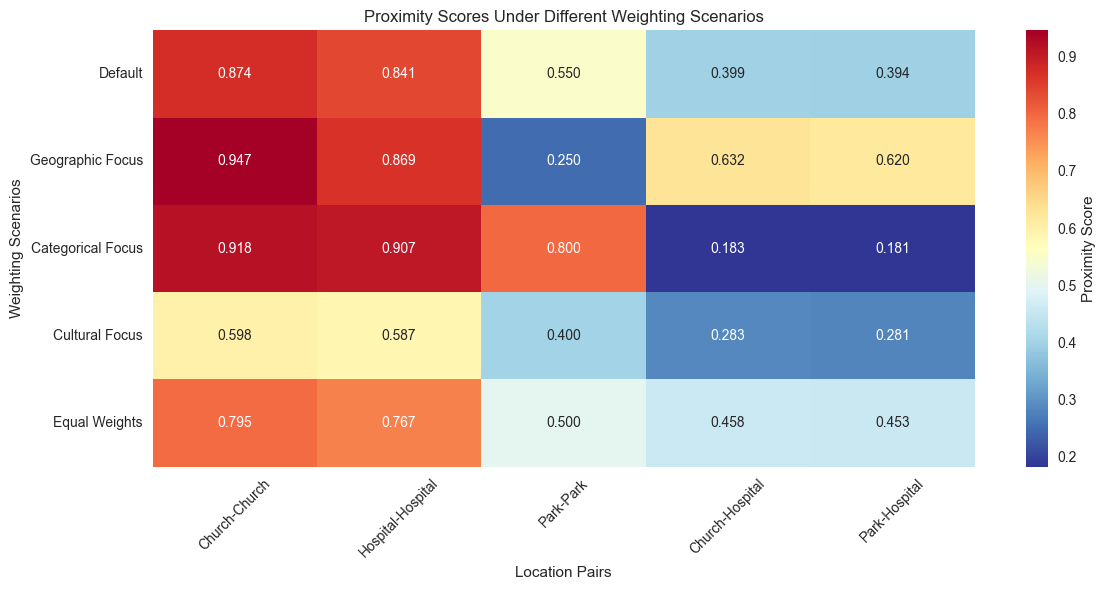

In [10]:
# Create heatmap of proximity scores
fig, ax = plt.subplots(figsize=(12, 6))

# Prepare data for heatmap
scenarios = list(weight_scenarios.keys())
proximity_matrix = np.array([results[scenario] for scenario in scenarios])

# Create heatmap
sns.heatmap(proximity_matrix, 
            xticklabels=pair_names,
            yticklabels=scenarios,
            annot=True, 
            fmt='.3f',
            cmap='RdYlBu_r',
            cbar_kws={'label': 'Proximity Score'})

plt.title('Proximity Scores Under Different Weighting Scenarios')
plt.xlabel('Location Pairs')
plt.ylabel('Weighting Scenarios')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Component Contribution Analysis

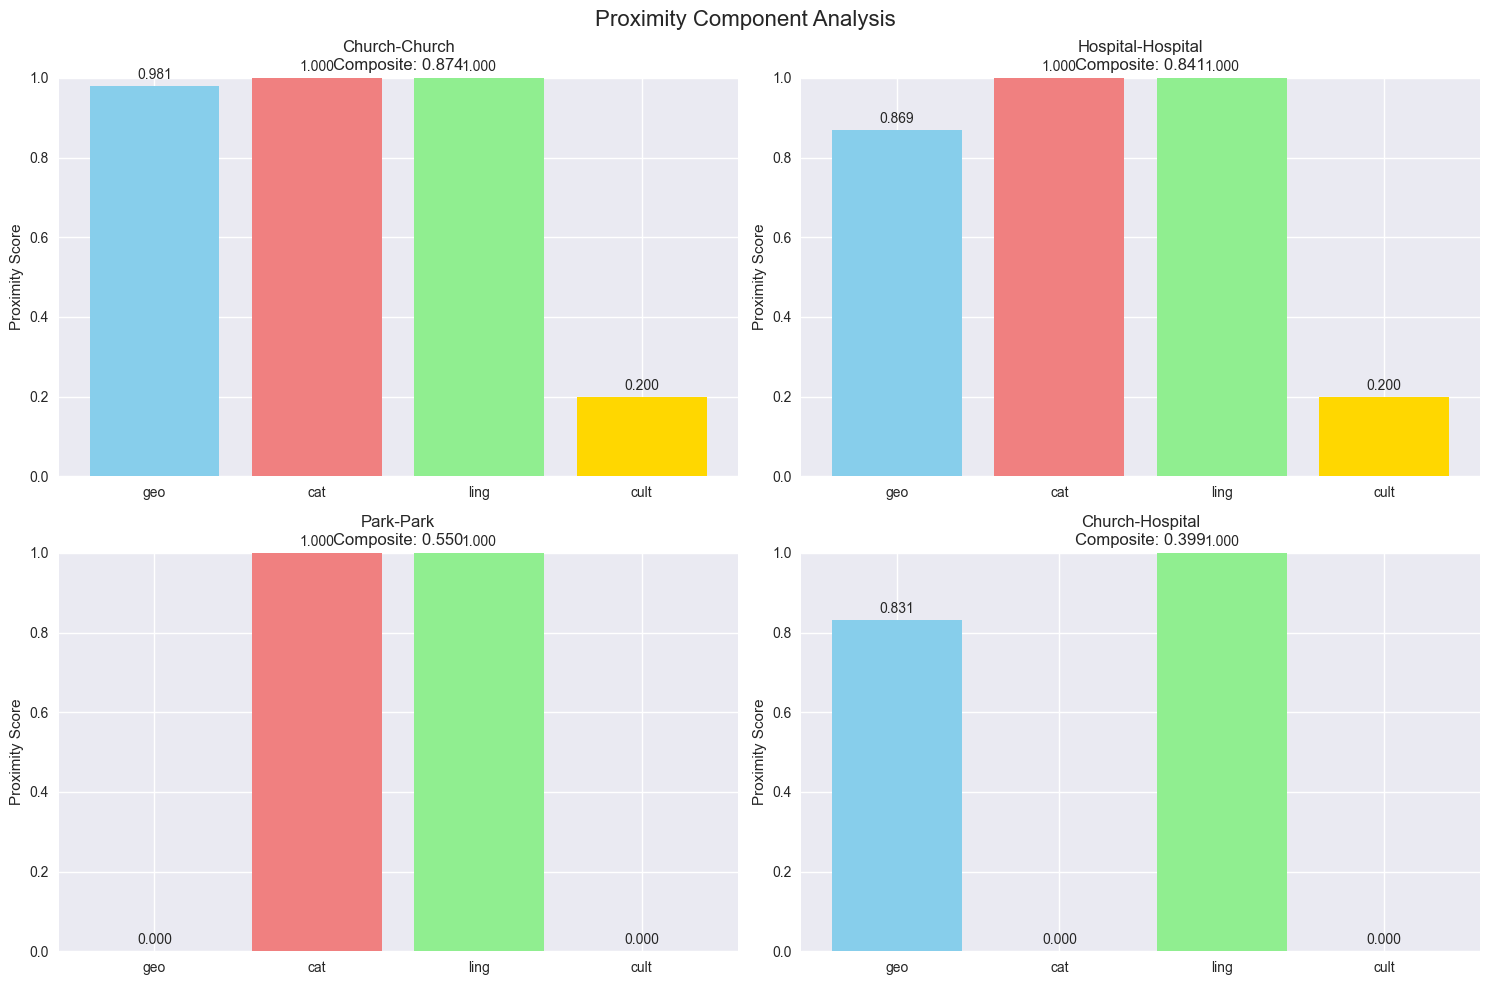

In [11]:
# Analyze component contributions for interesting pairs
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

# Select 4 interesting pairs
selected_pairs = test_pairs[:4]

for i, (loc1, loc2, pair_name) in enumerate(selected_pairs):
    # Calculate components with default weights
    result = composite_proximity(loc1, loc2)
    components = result['components']
    
    # Create bar plot
    comp_names = list(components.keys())
    comp_scores = list(components.values())
    
    bars = axes[i].bar(comp_names, comp_scores, 
                      color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
    axes[i].set_title(f'{pair_name}\nComposite: {result["composite"]:.3f}')
    axes[i].set_ylabel('Proximity Score')
    axes[i].set_ylim(0, 1)
    
    # Add value labels on bars
    for bar, score in zip(bars, comp_scores):
        axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{score:.3f}', ha='center', va='bottom')

plt.suptitle('Proximity Component Analysis', fontsize=16)
plt.tight_layout()
plt.show()

## Distance vs Proximity Relationship

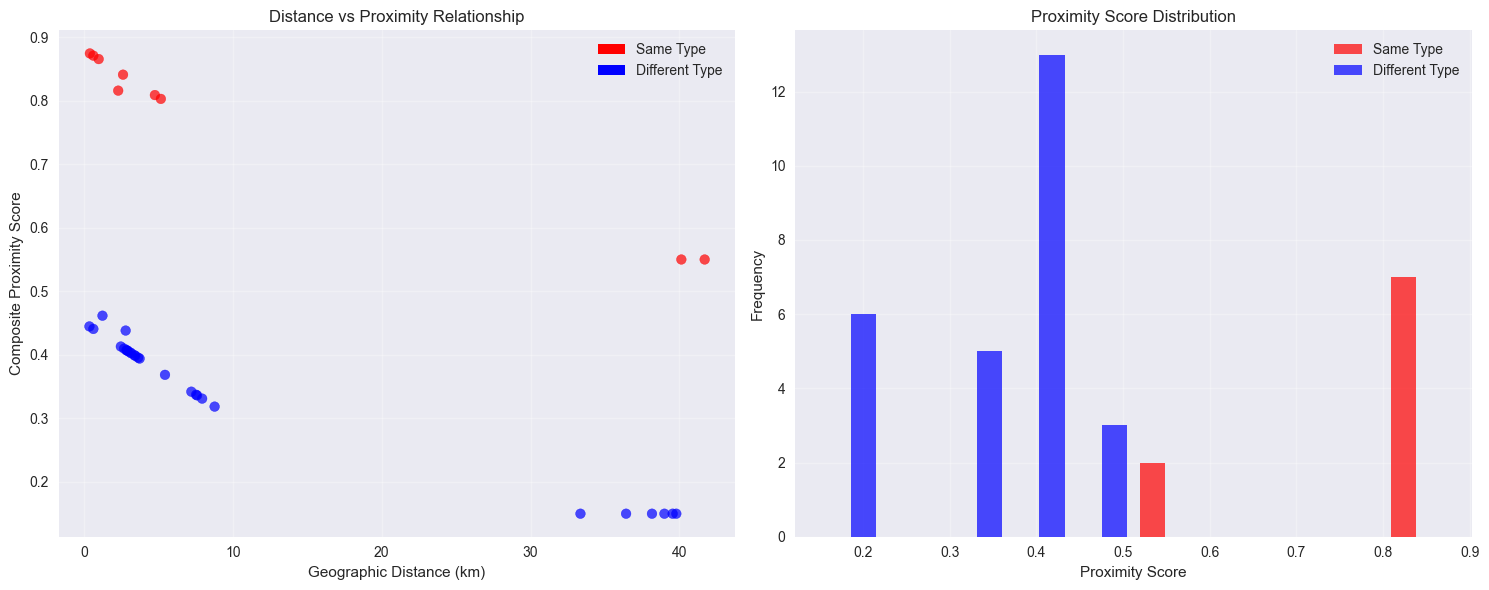

Same type pairs - Mean proximity: 0.775
Different type pairs - Mean proximity: 0.339


In [12]:
# Calculate all pairwise distances and proximities
distances = []
proximities = []
pair_types = []

for i, loc1 in enumerate(locations):
    for j, loc2 in enumerate(locations):
        if i < j:  # Avoid duplicates
            # Calculate distance
            dist = haversine_distance(
                loc1['coordinates']['lat'], loc1['coordinates']['lon'],
                loc2['coordinates']['lat'], loc2['coordinates']['lon']
            )
            
            # Calculate composite proximity
            prox = composite_proximity(loc1, loc2)['composite']
            
            distances.append(dist)
            proximities.append(prox)
            
            # Determine pair type
            if loc1['type'] == loc2['type']:
                pair_types.append('Same Type')
            else:
                pair_types.append('Different Type')

# Create scatter plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Distance vs Proximity
colors = ['red' if pt == 'Same Type' else 'blue' for pt in pair_types]
ax1.scatter(distances, proximities, c=colors, alpha=0.7)
ax1.set_xlabel('Geographic Distance (km)')
ax1.set_ylabel('Composite Proximity Score')
ax1.set_title('Distance vs Proximity Relationship')
ax1.grid(True, alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='red', label='Same Type'),
                  Patch(facecolor='blue', label='Different Type')]
ax1.legend(handles=legend_elements)

# Plot 2: Proximity distribution by type
same_type_prox = [p for p, t in zip(proximities, pair_types) if t == 'Same Type']
diff_type_prox = [p for p, t in zip(proximities, pair_types) if t == 'Different Type']

ax2.hist([same_type_prox, diff_type_prox], 
         bins=10, alpha=0.7, 
         label=['Same Type', 'Different Type'],
         color=['red', 'blue'])
ax2.set_xlabel('Proximity Score')
ax2.set_ylabel('Frequency')
ax2.set_title('Proximity Score Distribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Same type pairs - Mean proximity: {np.mean(same_type_prox):.3f}")
print(f"Different type pairs - Mean proximity: {np.mean(diff_type_prox):.3f}")

## Key Insights

1. **Categorical similarity dominates**: Same-type locations have much higher proximity scores
2. **Weight sensitivity**: Changing weights significantly affects results
3. **Geographic vs Semantic**: Physical distance matters less than semantic similarity
4. **Cultural tags**: Provide additional discrimination between similar place types

## Next Steps

1. Implement full module with optimized algorithms
2. Add more sophisticated cultural similarity measures
3. Integrate with emotion mapping
4. Test with real-world data